# Face Generation
In this project, we use generative adversarial networks (GANs) to generate new images of faces.
### Get the Data
Using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
# data_dir = '~/data'
# note: use full path on computer (not just ~)
data_dir = '/home/thojo/work/ud/deep-learning/face_generation/data'

import helper
import pickle as pkl
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

In [3]:
# """
# DON'T MODIFY ANYTHING IN THIS CELL
# """


# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

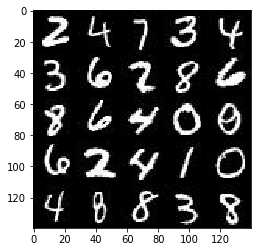

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

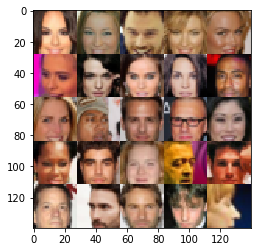

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/thojo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim ):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [43]:
def discriminator(images, reuse=False, alpha = 0.2, keep_prob = 0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # done: implement function
    with tf.variable_scope('discriminator', reuse=reuse):
            # Input layer is 28x28x1 for MNIST and celebA
            
            x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same') 
            # no batch_normalization in the first layer
            lrelu1 = tf.maximum( alpha*x1, x1)
            lrelu1 = tf.nn.dropout(lrelu1, keep_prob)
            # now 14x14x64

            x2 = tf.layers.conv2d(lrelu1, 128, 5, strides = 2, padding = 'same')
            bn2 = tf.layers.batch_normalization( x2, training = True )
            lrelu2 = tf.maximum( alpha*bn2, bn2)
            lrelu2 = tf.nn.dropout(lrelu2, keep_prob)
            # now 7x7x128

            x3 = tf.layers.conv2d(lrelu1, 256, 5, strides = 2, padding = 'same')
            bn3 = tf.layers.batch_normalization( x3, training = True )
            lrelu3 = tf.maximum( alpha*bn3, bn3)
            lrelu3 = tf.nn.dropout(lrelu3, keep_prob)
            # now 4x4x256

            flat = tf.reshape( lrelu3,(-1,4*4*256) ) 
            logits = tf.layers.dense( flat, 1 )
            out = tf.sigmoid( logits )

            return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [44]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):   
        # Fully connected
        x1 = tf.layers.dense(z, 2*2*256)
        # Reshape first layer as 2x2x256
        x1 = tf.reshape(x1, (-1, 2, 2, 256))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum( alpha*x1, x1) #leaky relu

        # Second layer as (7x7x128)
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='VALID')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum( alpha*x2, x2) #leaky relu
        
        # Third layer as (14x14x64)
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum( alpha*x3, x3) #leaky relu

        # Ouput layer as (28x28x out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')
        out = tf.tanh(logits)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [45]:
def model_loss(input_real, input_z, out_channel_dim ):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1 #For one-sided label smoothing (to prevent the discriminator from becoming too strong) 
    g_model = generator(input_z, out_channel_dim )
    d_model_real, d_logits_real = discriminator( input_real, reuse = False )
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True )

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(1-smooth)*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [46]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize, controlling dependencies approporiately
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [48]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode, print_every=100, show_every=200):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim )
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1 )
 
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        batch_num = 0
        for epoch_i in range(epoch_count):
            # Train Model
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2 #rescaling to match the (-1,1) range of the tanh outputs from the generator
                steps += 1
                batch_num += 1
                # Sample random noise for G 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run( d_opt, feed_dict={ input_real: batch_images, input_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run( g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar })
                    train_loss_g = g_loss.eval({ input_z: batch_z, learning_rate: learning_rate_scalar})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch # {}/{}...".format(batch_num, epoch_i+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch # 100/1... Discriminator Loss: 1.5875... Generator Loss: 0.7855
Epoch 1/2... Batch # 200/1... Discriminator Loss: 1.4729... Generator Loss: 0.8138
Epoch 1/2... Batch # 300/1... Discriminator Loss: 1.3728... Generator Loss: 0.8493
Epoch 1/2... Batch # 400/1... Discriminator Loss: 1.4098... Generator Loss: 1.0011
Epoch 1/2... Batch # 500/1... Discriminator Loss: 1.4882... Generator Loss: 1.0280


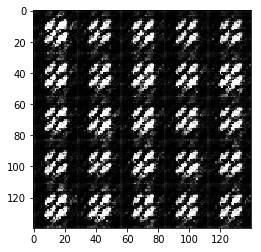

Epoch 1/2... Batch # 600/1... Discriminator Loss: 1.3038... Generator Loss: 1.0065
Epoch 1/2... Batch # 700/1... Discriminator Loss: 1.1608... Generator Loss: 1.0162
Epoch 1/2... Batch # 800/1... Discriminator Loss: 1.3026... Generator Loss: 0.9028
Epoch 1/2... Batch # 900/1... Discriminator Loss: 1.2779... Generator Loss: 0.9086
Epoch 1/2... Batch # 1000/1... Discriminator Loss: 1.2413... Generator Loss: 0.9381


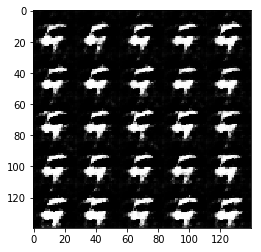

Epoch 1/2... Batch # 1100/1... Discriminator Loss: 1.2912... Generator Loss: 0.8753
Epoch 1/2... Batch # 1200/1... Discriminator Loss: 1.3838... Generator Loss: 0.8670
Epoch 1/2... Batch # 1300/1... Discriminator Loss: 1.1910... Generator Loss: 0.9192
Epoch 1/2... Batch # 1400/1... Discriminator Loss: 1.3453... Generator Loss: 0.9322
Epoch 1/2... Batch # 1500/1... Discriminator Loss: 1.2542... Generator Loss: 1.0115


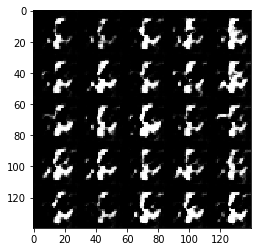

Epoch 1/2... Batch # 1600/1... Discriminator Loss: 1.2241... Generator Loss: 0.9691
Epoch 1/2... Batch # 1700/1... Discriminator Loss: 1.3386... Generator Loss: 0.8529
Epoch 1/2... Batch # 1800/1... Discriminator Loss: 1.2014... Generator Loss: 0.9474
Epoch 1/2... Batch # 1900/1... Discriminator Loss: 1.3366... Generator Loss: 0.8690
Epoch 1/2... Batch # 2000/1... Discriminator Loss: 1.1559... Generator Loss: 0.9358


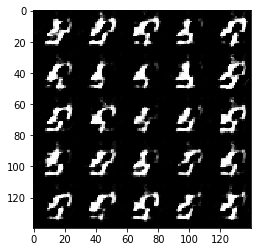

Epoch 1/2... Batch # 2100/1... Discriminator Loss: 1.2428... Generator Loss: 0.9560
Epoch 1/2... Batch # 2200/1... Discriminator Loss: 1.4000... Generator Loss: 0.9813
Epoch 1/2... Batch # 2300/1... Discriminator Loss: 1.3275... Generator Loss: 1.0103
Epoch 1/2... Batch # 2400/1... Discriminator Loss: 1.2785... Generator Loss: 1.1029
Epoch 1/2... Batch # 2500/1... Discriminator Loss: 1.2536... Generator Loss: 0.9796


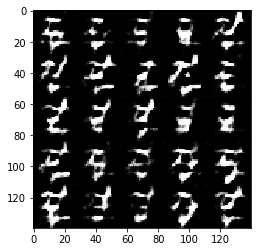

Epoch 1/2... Batch # 2600/1... Discriminator Loss: 1.3132... Generator Loss: 1.0188
Epoch 1/2... Batch # 2700/1... Discriminator Loss: 1.2675... Generator Loss: 0.8761
Epoch 1/2... Batch # 2800/1... Discriminator Loss: 1.2818... Generator Loss: 0.9785
Epoch 1/2... Batch # 2900/1... Discriminator Loss: 1.2802... Generator Loss: 0.9290
Epoch 1/2... Batch # 3000/1... Discriminator Loss: 1.2943... Generator Loss: 0.9474


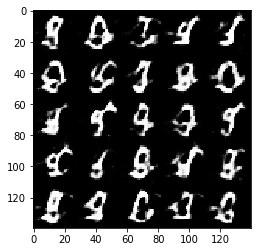

Epoch 1/2... Batch # 3100/1... Discriminator Loss: 1.2671... Generator Loss: 0.8767
Epoch 1/2... Batch # 3200/1... Discriminator Loss: 1.2902... Generator Loss: 0.8554
Epoch 1/2... Batch # 3300/1... Discriminator Loss: 1.2431... Generator Loss: 0.8170
Epoch 1/2... Batch # 3400/1... Discriminator Loss: 1.1964... Generator Loss: 0.9305
Epoch 1/2... Batch # 3500/1... Discriminator Loss: 1.2300... Generator Loss: 0.8762


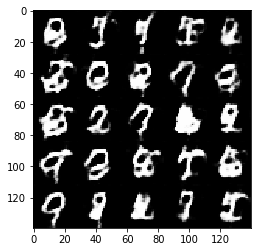

Epoch 1/2... Batch # 3600/1... Discriminator Loss: 1.3166... Generator Loss: 1.0423
Epoch 1/2... Batch # 3700/1... Discriminator Loss: 1.3429... Generator Loss: 0.9813
Epoch 2/2... Batch # 3800/2... Discriminator Loss: 1.3190... Generator Loss: 0.8699
Epoch 2/2... Batch # 3900/2... Discriminator Loss: 1.3360... Generator Loss: 0.8401
Epoch 2/2... Batch # 4000/2... Discriminator Loss: 1.1885... Generator Loss: 0.9956


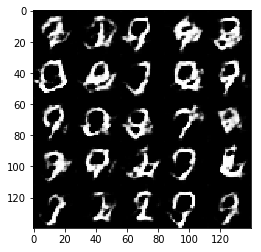

Epoch 2/2... Batch # 4100/2... Discriminator Loss: 1.3339... Generator Loss: 0.9388
Epoch 2/2... Batch # 4200/2... Discriminator Loss: 1.2774... Generator Loss: 0.8095
Epoch 2/2... Batch # 4300/2... Discriminator Loss: 1.3526... Generator Loss: 0.9178
Epoch 2/2... Batch # 4400/2... Discriminator Loss: 1.2883... Generator Loss: 0.8534
Epoch 2/2... Batch # 4500/2... Discriminator Loss: 1.3254... Generator Loss: 0.9146


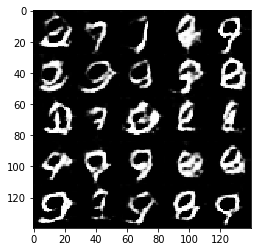

Epoch 2/2... Batch # 4600/2... Discriminator Loss: 1.3512... Generator Loss: 0.9866
Epoch 2/2... Batch # 4700/2... Discriminator Loss: 1.3806... Generator Loss: 0.8694
Epoch 2/2... Batch # 4800/2... Discriminator Loss: 1.4920... Generator Loss: 0.9468
Epoch 2/2... Batch # 4900/2... Discriminator Loss: 1.3538... Generator Loss: 0.9124
Epoch 2/2... Batch # 5000/2... Discriminator Loss: 1.3726... Generator Loss: 0.8567


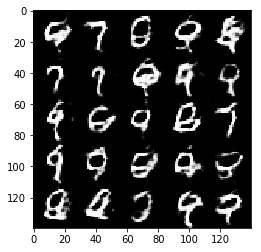

Epoch 2/2... Batch # 5100/2... Discriminator Loss: 1.3012... Generator Loss: 0.9124
Epoch 2/2... Batch # 5200/2... Discriminator Loss: 1.3333... Generator Loss: 0.8603
Epoch 2/2... Batch # 5300/2... Discriminator Loss: 1.3952... Generator Loss: 0.8914
Epoch 2/2... Batch # 5400/2... Discriminator Loss: 1.3027... Generator Loss: 0.8853
Epoch 2/2... Batch # 5500/2... Discriminator Loss: 1.3203... Generator Loss: 0.9866


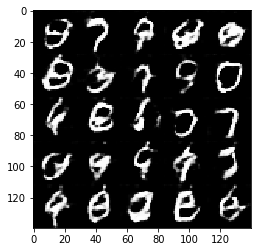

Epoch 2/2... Batch # 5600/2... Discriminator Loss: 1.3415... Generator Loss: 0.8169
Epoch 2/2... Batch # 5700/2... Discriminator Loss: 1.3163... Generator Loss: 0.8415
Epoch 2/2... Batch # 5800/2... Discriminator Loss: 1.3455... Generator Loss: 0.9570
Epoch 2/2... Batch # 5900/2... Discriminator Loss: 1.3543... Generator Loss: 0.8456
Epoch 2/2... Batch # 6000/2... Discriminator Loss: 1.3225... Generator Loss: 0.8228


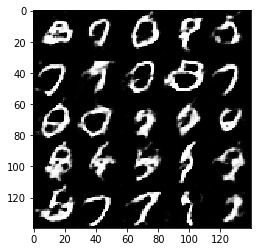

Epoch 2/2... Batch # 6100/2... Discriminator Loss: 1.4283... Generator Loss: 0.8872
Epoch 2/2... Batch # 6200/2... Discriminator Loss: 1.3743... Generator Loss: 0.8908
Epoch 2/2... Batch # 6300/2... Discriminator Loss: 1.3108... Generator Loss: 0.8646
Epoch 2/2... Batch # 6400/2... Discriminator Loss: 1.3424... Generator Loss: 0.8051
Epoch 2/2... Batch # 6500/2... Discriminator Loss: 1.3360... Generator Loss: 0.8301


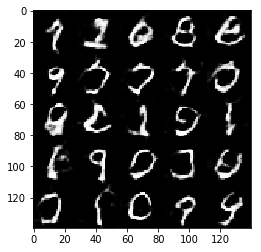

Epoch 2/2... Batch # 6600/2... Discriminator Loss: 1.3441... Generator Loss: 0.9286
Epoch 2/2... Batch # 6700/2... Discriminator Loss: 1.3700... Generator Loss: 0.8756
Epoch 2/2... Batch # 6800/2... Discriminator Loss: 1.3351... Generator Loss: 0.9109
Epoch 2/2... Batch # 6900/2... Discriminator Loss: 1.3707... Generator Loss: 0.8404
Epoch 2/2... Batch # 7000/2... Discriminator Loss: 1.2967... Generator Loss: 0.8385


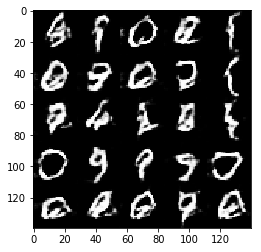

Epoch 2/2... Batch # 7100/2... Discriminator Loss: 1.3161... Generator Loss: 0.8241
Epoch 2/2... Batch # 7200/2... Discriminator Loss: 1.4480... Generator Loss: 0.7916
Epoch 2/2... Batch # 7300/2... Discriminator Loss: 1.3743... Generator Loss: 0.9020
Epoch 2/2... Batch # 7400/2... Discriminator Loss: 1.2811... Generator Loss: 0.8930
Epoch 2/2... Batch # 7500/2... Discriminator Loss: 1.3295... Generator Loss: 0.8439


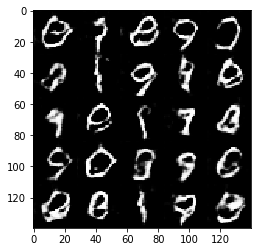

In [49]:
batch_size = 16 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2

print_every = 100
show_every = 500
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, 
          mnist_dataset.image_mode, print_every, show_every)

__Project notes for MNIST:__ With batch_size of 32, we can use slightly larger learning rates (0.0005) and get d_loss of 1.17 with g_loss of 0.76

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch # 100/1... Discriminator Loss: 1.6467... Generator Loss: 0.9994
Epoch 1/1... Batch # 200/1... Discriminator Loss: 1.2591... Generator Loss: 1.2912
Epoch 1/1... Batch # 300/1... Discriminator Loss: 1.1313... Generator Loss: 1.4348
Epoch 1/1... Batch # 400/1... Discriminator Loss: 1.2250... Generator Loss: 0.9014
Epoch 1/1... Batch # 500/1... Discriminator Loss: 1.1459... Generator Loss: 0.9207


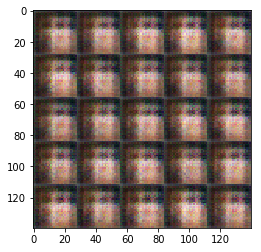

Epoch 1/1... Batch # 600/1... Discriminator Loss: 1.0569... Generator Loss: 0.9691
Epoch 1/1... Batch # 700/1... Discriminator Loss: 0.8789... Generator Loss: 1.2956
Epoch 1/1... Batch # 800/1... Discriminator Loss: 0.8552... Generator Loss: 1.2927
Epoch 1/1... Batch # 900/1... Discriminator Loss: 0.8703... Generator Loss: 1.4005
Epoch 1/1... Batch # 1000/1... Discriminator Loss: 0.8375... Generator Loss: 1.5883


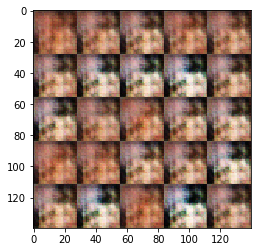

Epoch 1/1... Batch # 1100/1... Discriminator Loss: 0.9164... Generator Loss: 1.6480
Epoch 1/1... Batch # 1200/1... Discriminator Loss: 0.9329... Generator Loss: 1.3028
Epoch 1/1... Batch # 1300/1... Discriminator Loss: 0.7590... Generator Loss: 1.7380
Epoch 1/1... Batch # 1400/1... Discriminator Loss: 0.7782... Generator Loss: 1.7976
Epoch 1/1... Batch # 1500/1... Discriminator Loss: 0.8729... Generator Loss: 1.2501


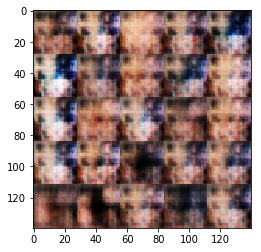

Epoch 1/1... Batch # 1600/1... Discriminator Loss: 0.9165... Generator Loss: 1.4031
Epoch 1/1... Batch # 1700/1... Discriminator Loss: 0.9408... Generator Loss: 1.3361
Epoch 1/1... Batch # 1800/1... Discriminator Loss: 1.0242... Generator Loss: 1.4266
Epoch 1/1... Batch # 1900/1... Discriminator Loss: 0.8844... Generator Loss: 1.5024
Epoch 1/1... Batch # 2000/1... Discriminator Loss: 0.9191... Generator Loss: 1.6639


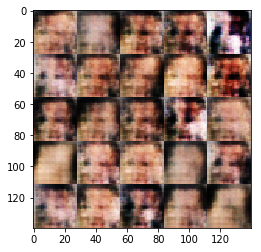

Epoch 1/1... Batch # 2100/1... Discriminator Loss: 1.0499... Generator Loss: 1.1290
Epoch 1/1... Batch # 2200/1... Discriminator Loss: 0.9052... Generator Loss: 1.7086
Epoch 1/1... Batch # 2300/1... Discriminator Loss: 1.0257... Generator Loss: 1.2145
Epoch 1/1... Batch # 2400/1... Discriminator Loss: 0.9256... Generator Loss: 1.4168
Epoch 1/1... Batch # 2500/1... Discriminator Loss: 0.8668... Generator Loss: 1.9441


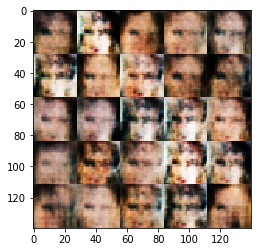

Epoch 1/1... Batch # 2600/1... Discriminator Loss: 0.8874... Generator Loss: 1.5568
Epoch 1/1... Batch # 2700/1... Discriminator Loss: 0.9476... Generator Loss: 1.4574
Epoch 1/1... Batch # 2800/1... Discriminator Loss: 0.9158... Generator Loss: 1.7084
Epoch 1/1... Batch # 2900/1... Discriminator Loss: 0.9161... Generator Loss: 1.8106
Epoch 1/1... Batch # 3000/1... Discriminator Loss: 0.8184... Generator Loss: 2.1990


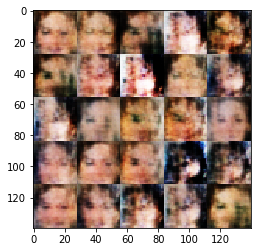

Epoch 1/1... Batch # 3100/1... Discriminator Loss: 0.9681... Generator Loss: 1.3693
Epoch 1/1... Batch # 3200/1... Discriminator Loss: 0.9849... Generator Loss: 1.3924
Epoch 1/1... Batch # 3300/1... Discriminator Loss: 0.8549... Generator Loss: 1.3762
Epoch 1/1... Batch # 3400/1... Discriminator Loss: 1.0716... Generator Loss: 1.3592
Epoch 1/1... Batch # 3500/1... Discriminator Loss: 1.0838... Generator Loss: 1.6193


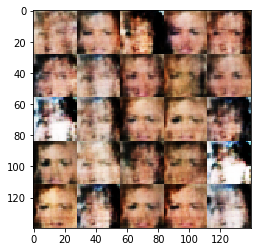

Epoch 1/1... Batch # 3600/1... Discriminator Loss: 1.0570... Generator Loss: 1.3773
Epoch 1/1... Batch # 3700/1... Discriminator Loss: 1.0349... Generator Loss: 1.6123
Epoch 1/1... Batch # 3800/1... Discriminator Loss: 1.0878... Generator Loss: 1.3237
Epoch 1/1... Batch # 3900/1... Discriminator Loss: 1.2668... Generator Loss: 1.5208
Epoch 1/1... Batch # 4000/1... Discriminator Loss: 1.3392... Generator Loss: 0.9254


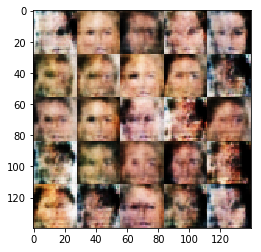

Epoch 1/1... Batch # 4100/1... Discriminator Loss: 1.1884... Generator Loss: 1.2757
Epoch 1/1... Batch # 4200/1... Discriminator Loss: 1.2788... Generator Loss: 1.2157
Epoch 1/1... Batch # 4300/1... Discriminator Loss: 1.0627... Generator Loss: 1.0712
Epoch 1/1... Batch # 4400/1... Discriminator Loss: 1.1513... Generator Loss: 1.0914
Epoch 1/1... Batch # 4500/1... Discriminator Loss: 1.2308... Generator Loss: 1.3005


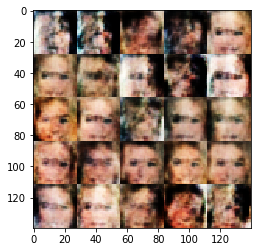

Epoch 1/1... Batch # 4600/1... Discriminator Loss: 1.3186... Generator Loss: 1.0232
Epoch 1/1... Batch # 4700/1... Discriminator Loss: 1.1569... Generator Loss: 1.0575
Epoch 1/1... Batch # 4800/1... Discriminator Loss: 1.2559... Generator Loss: 1.2432
Epoch 1/1... Batch # 4900/1... Discriminator Loss: 1.2407... Generator Loss: 1.1750
Epoch 1/1... Batch # 5000/1... Discriminator Loss: 1.0118... Generator Loss: 1.2026


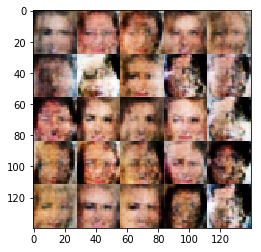

Epoch 1/1... Batch # 5100/1... Discriminator Loss: 1.2815... Generator Loss: 1.2776
Epoch 1/1... Batch # 5200/1... Discriminator Loss: 1.1823... Generator Loss: 1.2355
Epoch 1/1... Batch # 5300/1... Discriminator Loss: 1.3362... Generator Loss: 1.0481
Epoch 1/1... Batch # 5400/1... Discriminator Loss: 1.1041... Generator Loss: 1.1223
Epoch 1/1... Batch # 5500/1... Discriminator Loss: 1.2496... Generator Loss: 0.9046


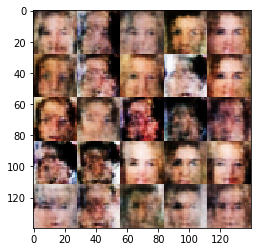

Epoch 1/1... Batch # 5600/1... Discriminator Loss: 1.1948... Generator Loss: 1.3252
Epoch 1/1... Batch # 5700/1... Discriminator Loss: 1.2437... Generator Loss: 1.0034
Epoch 1/1... Batch # 5800/1... Discriminator Loss: 1.1268... Generator Loss: 1.5864
Epoch 1/1... Batch # 5900/1... Discriminator Loss: 1.1231... Generator Loss: 1.3037
Epoch 1/1... Batch # 6000/1... Discriminator Loss: 1.1170... Generator Loss: 1.1859


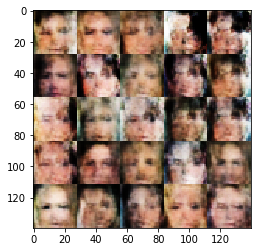

Epoch 1/1... Batch # 6100/1... Discriminator Loss: 1.3239... Generator Loss: 1.1166
Epoch 1/1... Batch # 6200/1... Discriminator Loss: 1.1750... Generator Loss: 0.9990
Epoch 1/1... Batch # 6300/1... Discriminator Loss: 1.3200... Generator Loss: 1.0418
Epoch 1/1... Batch # 6400/1... Discriminator Loss: 1.3103... Generator Loss: 0.9690
Epoch 1/1... Batch # 6500/1... Discriminator Loss: 1.0862... Generator Loss: 1.0198


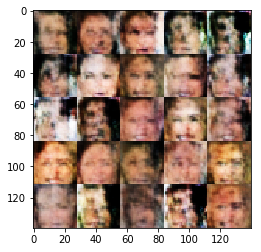

Epoch 1/1... Batch # 6600/1... Discriminator Loss: 1.2186... Generator Loss: 1.1589
Epoch 1/1... Batch # 6700/1... Discriminator Loss: 1.2361... Generator Loss: 1.0880
Epoch 1/1... Batch # 6800/1... Discriminator Loss: 1.1866... Generator Loss: 1.0623
Epoch 1/1... Batch # 6900/1... Discriminator Loss: 1.2229... Generator Loss: 1.0228
Epoch 1/1... Batch # 7000/1... Discriminator Loss: 1.1676... Generator Loss: 1.0394


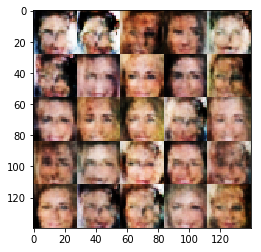

Epoch 1/1... Batch # 7100/1... Discriminator Loss: 1.2968... Generator Loss: 1.0721
Epoch 1/1... Batch # 7200/1... Discriminator Loss: 1.1350... Generator Loss: 1.0105
Epoch 1/1... Batch # 7300/1... Discriminator Loss: 1.2390... Generator Loss: 1.0854
Epoch 1/1... Batch # 7400/1... Discriminator Loss: 1.2753... Generator Loss: 1.0369
Epoch 1/1... Batch # 7500/1... Discriminator Loss: 1.2972... Generator Loss: 1.0723


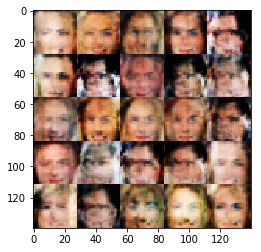

Epoch 1/1... Batch # 7600/1... Discriminator Loss: 1.3359... Generator Loss: 1.1039
Epoch 1/1... Batch # 7700/1... Discriminator Loss: 1.3541... Generator Loss: 1.2149
Epoch 1/1... Batch # 7800/1... Discriminator Loss: 1.1769... Generator Loss: 0.9828
Epoch 1/1... Batch # 7900/1... Discriminator Loss: 1.3041... Generator Loss: 1.0999
Epoch 1/1... Batch # 8000/1... Discriminator Loss: 1.4173... Generator Loss: 1.1702


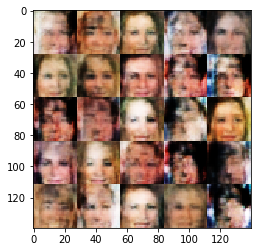

Epoch 1/1... Batch # 8100/1... Discriminator Loss: 1.1968... Generator Loss: 1.0851
Epoch 1/1... Batch # 8200/1... Discriminator Loss: 1.1143... Generator Loss: 1.1140
Epoch 1/1... Batch # 8300/1... Discriminator Loss: 1.3073... Generator Loss: 0.9806
Epoch 1/1... Batch # 8400/1... Discriminator Loss: 1.1948... Generator Loss: 1.0544
Epoch 1/1... Batch # 8500/1... Discriminator Loss: 1.2231... Generator Loss: 1.1452


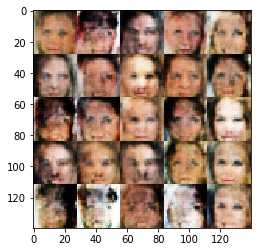

Epoch 1/1... Batch # 8600/1... Discriminator Loss: 1.1583... Generator Loss: 1.0619
Epoch 1/1... Batch # 8700/1... Discriminator Loss: 1.2569... Generator Loss: 1.1497
Epoch 1/1... Batch # 8800/1... Discriminator Loss: 1.2614... Generator Loss: 0.9740
Epoch 1/1... Batch # 8900/1... Discriminator Loss: 1.2515... Generator Loss: 1.1411
Epoch 1/1... Batch # 9000/1... Discriminator Loss: 1.2408... Generator Loss: 1.0402


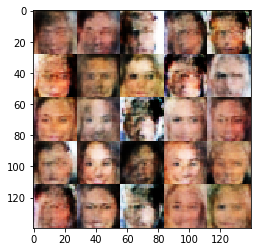

Epoch 1/1... Batch # 9100/1... Discriminator Loss: 1.2732... Generator Loss: 1.0895
Epoch 1/1... Batch # 9200/1... Discriminator Loss: 1.2010... Generator Loss: 0.9158
Epoch 1/1... Batch # 9300/1... Discriminator Loss: 1.2663... Generator Loss: 0.9655
Epoch 1/1... Batch # 9400/1... Discriminator Loss: 1.1364... Generator Loss: 1.0366
Epoch 1/1... Batch # 9500/1... Discriminator Loss: 1.2089... Generator Loss: 0.9051


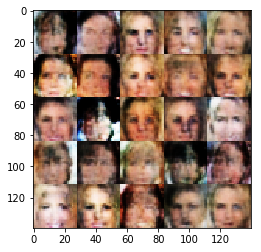

Epoch 1/1... Batch # 9600/1... Discriminator Loss: 1.2736... Generator Loss: 1.1178
Epoch 1/1... Batch # 9700/1... Discriminator Loss: 1.2788... Generator Loss: 1.0631
Epoch 1/1... Batch # 9800/1... Discriminator Loss: 1.2894... Generator Loss: 0.9429
Epoch 1/1... Batch # 9900/1... Discriminator Loss: 1.2735... Generator Loss: 1.1621
Epoch 1/1... Batch # 10000/1... Discriminator Loss: 1.1959... Generator Loss: 0.9591


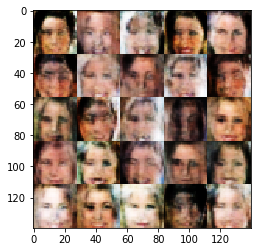

Epoch 1/1... Batch # 10100/1... Discriminator Loss: 1.2267... Generator Loss: 1.1487
Epoch 1/1... Batch # 10200/1... Discriminator Loss: 1.2420... Generator Loss: 1.0224
Epoch 1/1... Batch # 10300/1... Discriminator Loss: 1.2055... Generator Loss: 0.8907
Epoch 1/1... Batch # 10400/1... Discriminator Loss: 1.3041... Generator Loss: 1.1459
Epoch 1/1... Batch # 10500/1... Discriminator Loss: 1.2462... Generator Loss: 1.0952


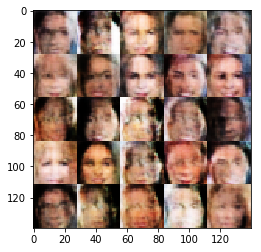

Epoch 1/1... Batch # 10600/1... Discriminator Loss: 1.3337... Generator Loss: 0.9788
Epoch 1/1... Batch # 10700/1... Discriminator Loss: 1.2969... Generator Loss: 0.9939
Epoch 1/1... Batch # 10800/1... Discriminator Loss: 1.2533... Generator Loss: 0.8801
Epoch 1/1... Batch # 10900/1... Discriminator Loss: 1.1805... Generator Loss: 0.9277
Epoch 1/1... Batch # 11000/1... Discriminator Loss: 1.2237... Generator Loss: 0.9382


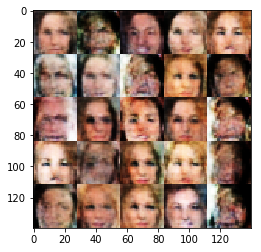

Epoch 1/1... Batch # 11100/1... Discriminator Loss: 1.2691... Generator Loss: 1.3386
Epoch 1/1... Batch # 11200/1... Discriminator Loss: 1.3486... Generator Loss: 1.0921
Epoch 1/1... Batch # 11300/1... Discriminator Loss: 1.2248... Generator Loss: 0.9334
Epoch 1/1... Batch # 11400/1... Discriminator Loss: 1.3171... Generator Loss: 0.9317
Epoch 1/1... Batch # 11500/1... Discriminator Loss: 1.1525... Generator Loss: 1.0577


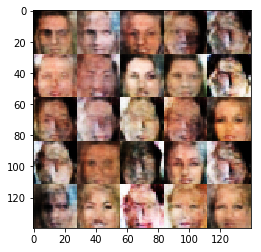

Epoch 1/1... Batch # 11600/1... Discriminator Loss: 1.2571... Generator Loss: 1.0435
Epoch 1/1... Batch # 11700/1... Discriminator Loss: 1.2661... Generator Loss: 0.9778
Epoch 1/1... Batch # 11800/1... Discriminator Loss: 1.1826... Generator Loss: 0.9855
Epoch 1/1... Batch # 11900/1... Discriminator Loss: 1.2656... Generator Loss: 1.0790
Epoch 1/1... Batch # 12000/1... Discriminator Loss: 1.1224... Generator Loss: 0.9925


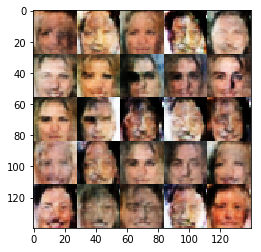

Epoch 1/1... Batch # 12100/1... Discriminator Loss: 1.2984... Generator Loss: 0.9667
Epoch 1/1... Batch # 12200/1... Discriminator Loss: 1.1920... Generator Loss: 1.0227
Epoch 1/1... Batch # 12300/1... Discriminator Loss: 1.1753... Generator Loss: 0.9440
Epoch 1/1... Batch # 12400/1... Discriminator Loss: 1.3393... Generator Loss: 1.0906
Epoch 1/1... Batch # 12500/1... Discriminator Loss: 1.2794... Generator Loss: 0.9331


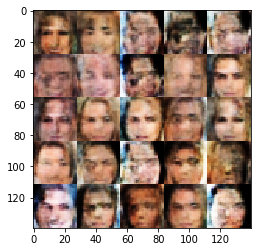

Epoch 1/1... Batch # 12600/1... Discriminator Loss: 1.3036... Generator Loss: 1.1887


In [50]:
batch_size = 16 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2

print_every = 100
show_every = 500
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, print_every, show_every)

__Porject notes:__ 

I have tried batch sizes of 16, 32, 64 and 128.  For smaller batches, the learning rate needs to be smaller too (as the gradients are more likely to go unstable).  Thanks to reviewer for suggesting going as low as 16!

For learning rates, I went from 0.0002 to 0.0008.  Batch size 32 with a learning rate of 0.0005 seems to perform well for MNIST. However, for celebA, a smaller batch size (16), a smaller learning rate (0.0003) produces better images. d_loss was 1.34 and g_loss is 0.80.

Tried dropout.  For celebA, with batch_size = 16, lr=0.0002, dropout with keep_prob = 0.5 resulted in OK faces with d_loss=1.31 and g_loss =1.18 

I have also run this upto 50 epochs on AWS and that gave sharper and better outputs.  This is from the roughly 1 GB GPU that I have on my local machine.  FOr the project, we're looking at performance with just 1 epoch.  

Faces are recognizable in a single epoch.  I have tried beta1 values of 0.9, 0.5 and also lower values. 0.2 is good, as is 0.3.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.